In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [12]:
# Read in all dataframes
dfs = []
k = 0
for f in os.scandir("./coords/posenet"):
    if f.is_file() and f.name != '.DS_Store':
        df = pd.read_csv(f)
        df['class'] = k
        dfs.append(df)
        k += 1
        
dfs[0].head()

score  nose_score  leftEye_score  rightEye_score  leftEar_score  \
0  0.565957    0.999123       0.998200        0.996400       0.924315   
1  0.545799    0.990537       0.991718        0.992416       0.585613   
2  0.657214    0.998008       0.990955        0.986429       0.671019   
3  0.588887    0.990551       0.998967        0.999236       0.588298   
4  0.780212    0.998642       0.986117        0.996111       0.916750   

   rightEar_score  leftShoulder_score  rightShoulder_score  leftElbow_score  \
0        0.947072            0.957494             0.947747         0.062188   
1        0.289436            0.821773             0.936248         0.396081   
2        0.248268            0.966711             0.986788         0.902529   
3        0.714369            0.787232             0.810225         0.863416   
4        0.888298            0.915750             0.875743         0.984774   

   rightElbow_score  ...   rightHip_x  leftKnee_y   leftKnee_x  rightKnee_y  \
0          0.152223  ...   183.242909  415.273558   215.838174   366.027177   
1          0.026364  ...   210.280452  478.801242   238.659256   441.879988   
2          0.033043  ...   299.850258  314.979777   419.893105   349.013720   
3          0.685289  ...  1023.983170  649.718255  1305.485842   749.196573   
4          0.833988  ...   141.234296  197.203453   228.542591   236.904748   

   rightKnee_x  leftAnkle_y  leftAnkle_x  rightAnkle_y  rightAnkle_x  class  
0   160.726307   527.887454   206.924328    505.618097    131.604030      0  
1   143.778982   580.143367   233.357855    505.307716    211.428675      0  
2   323.449590   301.494596   337.986366    446.779468    341.193836      0  
3  1068.610535   686.690766  1214.431514    910.851472   1102.573775      0  
4   150.821788   208.283654   167.932071    320.456794    167.368610      0  

[5 rows x 53 columns]

In [13]:
# Combine and clean
combined_dfs = pd.concat(dfs, ignore_index=True)
combined_dfs = combined_dfs[combined_dfs['score'] > 0]
combined_dfs.head(10)

score  nose_score  leftEye_score  rightEye_score  leftEar_score  \
0   0.565957    0.999123       0.998200        0.996400       0.924315   
1   0.545799    0.990537       0.991718        0.992416       0.585613   
2   0.657214    0.998008       0.990955        0.986429       0.671019   
3   0.588887    0.990551       0.998967        0.999236       0.588298   
4   0.780212    0.998642       0.986117        0.996111       0.916750   
6   0.320456    0.992034       0.989887        0.984465       0.522624   
7   0.519308    0.993420       0.969485        0.982689       0.825834   
8   0.572921    0.998473       0.995711        0.990893       0.612365   
9   0.654948    0.996756       0.998862        0.994826       0.919350   
11  0.323536    0.997084       0.952093        0.993184       0.603156   

    rightEar_score  leftShoulder_score  rightShoulder_score  leftElbow_score  \
0         0.947072            0.957494             0.947747         0.062188   
1         0.289436            0.821773             0.936248         0.396081   
2         0.248268            0.966711             0.986788         0.902529   
3         0.714369            0.787232             0.810225         0.863416   
4         0.888298            0.915750             0.875743         0.984774   
6         0.356904            0.069622             0.023593         0.009006   
7         0.199253            0.933107             0.950390         0.258882   
8         0.850215            0.690414             0.993599         0.969429   
9         0.862116            0.939991             0.860165         0.862497   
11        0.211177            0.167704             0.154886         0.002687   

    rightElbow_score  ...   rightHip_x  leftKnee_y   leftKnee_x  rightKnee_y  \
0           0.152223  ...   183.242909  415.273558   215.838174   366.027177   
1           0.026364  ...   210.280452  478.801242   238.659256   441.879988   
2           0.033043  ...   299.850258  314.979777   419.893105   349.013720   
3           0.685289  ...  1023.983170  649.718255  1305.485842   749.196573   
4           0.833988  ...   141.234296  197.203453   228.542591   236.904748   
6           0.010524  ...   238.211072  827.517187   416.996199   863.073875   
7           0.116492  ...   183.545710  308.315362   291.548805   360.077651   
8           0.174427  ...   174.207011  259.229171   204.357354   227.566659   
9           0.301358  ...   680.227274  422.080787   869.131618   482.840862   
11          0.002500  ...   229.334778  655.863441   293.504668   588.751114   

    rightKnee_x  leftAnkle_y  leftAnkle_x  rightAnkle_y  rightAnkle_x  class  
0    160.726307   527.887454   206.924328    505.618097    131.604030      0  
1    143.778982   580.143367   233.357855    505.307716    211.428675      0  
2    323.449590   301.494596   337.986366    446.779468    341.193836      0  
3   1068.610535   686.690766  1214.431514    910.851472   1102.573775      0  
4    150.821788   208.283654   167.932071    320.456794    167.368610      0  
6    251.958108   820.967826   349.356618   1000.234836    284.125446      0  
7    190.110716   326.342882   215.612441    422.393876    199.415554      0  
8    112.585318   328.002699   192.046343    232.811221    166.650798      0  
9    706.028387   472.031740   780.380224    632.819678    726.409162      0  
11   134.437047   773.191254   289.832523    642.420684    260.400296      0  

[10 rows x 53 columns]

In [14]:
# Create ground truth y
y = []

# Grab every possible combination of 2 rows
for index in list(combinations(combined_dfs.index,2)):
    y.append(int(combined_dfs['class'][index[0]] == combined_dfs['class'][index[1]]))

In [15]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (df): dataframe of (x,y) coordinates

    Returns:
    df: coords scaled to 1x1 with center at (0,0)
    """
    x_cols = [col for col in coords if col.endswith('x')]
    y_cols = [col for col in coords if col.endswith('y')]
    x_diff = coords[x_cols].max(axis=1) - coords[x_cols].min(axis=1)
    y_diff = coords[y_cols].max(axis=1) - coords[y_cols].min(axis=1)
    diff_max = pd.concat([x_diff, y_diff], axis=1).max(axis=1)

    coords[x_cols] = coords[x_cols].subtract(coords[x_cols].mean(axis=1), axis=0)\
                                   .div(diff_max, axis=0)
    coords[y_cols] = coords[y_cols].subtract(coords[y_cols].mean(axis=1), axis=0)\
                                   .div(diff_max, axis=0)
    coords.div(coords.pow(2, axis=1).sum(axis=1), axis=0)
    return coords

In [16]:
# Scale, transform, normalize vectors
filter_col = [col for col in combined_dfs if col.endswith('x') or col.endswith('y')]
coords = combined_dfs[filter_col]
scale_transform_normalize(coords)
coords.head()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


nose_y    nose_x  leftEye_y  leftEye_x  rightEye_y  rightEye_x  \
0 -0.311684  0.014952  -0.326337   0.033550   -0.326339   -0.004652   
1 -0.184686  0.007511  -0.200212   0.035779   -0.198868   -0.003183   
2 -0.306981 -0.018699  -0.325959   0.009511   -0.326504   -0.031812   
3 -0.310889 -0.025081  -0.335065  -0.003353   -0.334980   -0.048589   
4 -0.300617 -0.023632  -0.319211  -0.000994   -0.319503   -0.043493   

   leftEar_y  leftEar_x  rightEar_y  rightEar_x  ...  rightHip_y  rightHip_x  \
0  -0.319716   0.061064   -0.321941   -0.032391  ...    0.079726   -0.040541   
1  -0.185724   0.058371   -0.179296   -0.022652  ...    0.190338   -0.042335   
2  -0.300563   0.045630   -0.306108   -0.048140  ...    0.173605   -0.072639   
3  -0.315529   0.020977   -0.313853   -0.080345  ...    0.141180   -0.102852   
4  -0.302589   0.035667   -0.305643   -0.079776  ...    0.161602   -0.058700   

   leftKnee_y  leftKnee_x  rightKnee_y  rightKnee_x  leftAnkle_y  leftAnkle_x  \
0    0.430457    0.029852     0.324103    -0.089169     0.673661     0.010602   
1    0.436492    0.014741     0.362236    -0.176084     0.640314     0.004079   
2    0.349714    0.222261     0.433323    -0.014665     0.316586     0.021047   
3    0.331292    0.256816     0.458393    -0.045833     0.378531     0.140479   
4    0.267240    0.234037     0.400354    -0.026554     0.304391     0.030815   

   rightAnkle_y  rightAnkle_x  
0      0.625567     -0.152062  
1      0.489803     -0.040025  
2      0.673496      0.028926  
3      0.664935     -0.002439  
4      0.680497      0.028926  

[5 rows x 34 columns]

In [17]:
# Get y_pred
y_pred = []
# coords = coords.fillna(0)

# Grab every possible combination of 2 rows
for index in list(combinations(coords.index,2)):
    vec_1 = coords.loc[index[0]].values.reshape((1,34))
    vec_2 = coords.loc[index[1]].values.reshape((1,34))
    cosine_score = cosine_similarity(vec_1, vec_2)[0]
    y_pred.append(cosine_score)

AUC: 0.952


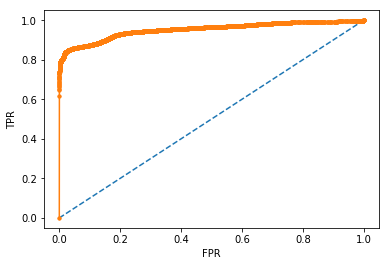

In [18]:
# Check ROC, AUC
fpr, tpr, thresholds = roc_curve(y, y_pred)
auc = roc_auc_score(y, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [19]:
print(thresholds)

[ 2.          1.          0.99490291 ... -0.5982616  -0.60705004
 -0.71089826]


In [20]:
combined_dfs.shape

(335, 53)